In [1]:
import torch
import matplotlib.pyplot as plt
from fastai.data.all import * 
import torchvision

## 시벤코정리 

`-` 아이디어: linear -> relu -> linear (-> sigmoid) 조합으로 꺾은선으로 표현되는 underlying 을 표현할 수 있었다. 
- 아이디어의 실용성: 실제자료에서 꺾은선으로 표현되는 underlying은 몇개 없을 것 같음. 
  - 그건 맞는데 꺾이는 점을 많이 설정하면 얼추 비슷하게는 "근사" 시킬 수 있음. 
- 아이디어의 확장성: 이러한 논리전개는 X: n x 2인 경우도 가능했음. (이 경우 꺾인평면이 된다)
- 아이디어에 해당하는 용어정리: : 이 구조가 x->y 로 바로 가는 것이 아니라 x->(u1->v1)->(u2->v2)=y 의 구조인데 
  - 이러한 네트워크를 하나의 은닉층을 포함하는 네트워크라고 표현한다. 

### 시벤코정리

**universal approximation thm: (범용근사정리,보편근사정리,시벤코정리)**, 1989

> 하나의 은닉층을 가지는 "linear -> sigmoid -> linear" 꼴의 네트워크를 이용하여 세상에 존재하는 모든 (다차원) 연속함수를 원하는 정확도로 근사시킬 수 있다. (계수를 잘 추정한다면)


`-` 사실 엄청 이해안되는 정리임. 왜냐햐면,
- 그렇게 잘 맞추면 1989년에 세상의 모든 문제를 다 풀어야 한거 아니야? 
- 요즘은 "linear -> sigmoid -> linear" 가 아니라 "linear -> relu -> linear" 조합으로 많이 쓰던데? 
- 요즘은 하나의 은닉층을 포함하는 네트워크는 잘 안쓰지 않나? 은닉층이 여러개일수록 좋다고 어디서 본 것 같은데?

`-` 약간의 의구심이 있지만 아무튼 universal approximation thm에 따르면 우리는 아래와 같은 무기를 가진 꼴이 된다. 
- 우리의 무기: ${\bf X}: (n,p)$ 꼴의 입력에서 ${\bf y}:(n,1)$ 꼴의 출력으로 향하는 맵핑을 "linear -> relu -> linear"와 같은 네트워크를 이용해서 "근사"시킬 수 있다.

## MNIST with DNN

### 목표 

`-` 목표: 
- ${\bf X}:(n,1,28,28)$ 에서 $y:(n,1)$ 로 가는 맵핑을 학습하자 
- --> 배운적이 없는데? 
- --> ${\bf X}:(n,784)$ 에서 $y:(n,1)$ 로 가는 맵핑을 학습하자.. 

### 예비학습1: Path

In [2]:
path = untar_data(URLs.MNIST) 
path

Path('/Users/gwagdoseong/.fastai/data/mnist_png')

- path 도 오브젝트임
- path 도 정보+기능이 있음 

`-` path의 정보

In [5]:
path._str # 숨겨놓았네?

'/Users/gwagdoseong/.fastai/data/mnist_png'

`-` 기능1

In [6]:
path.ls()

(#2) [Path('/Users/gwagdoseong/.fastai/data/mnist_png/training'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing')]

In [7]:
len(path.ls())

2

In [8]:
path.ls()[0]

Path('/Users/gwagdoseong/.fastai/data/mnist_png/training')

In [9]:
path.ls()[1]

Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing')

`-` 기능2

In [10]:
path/'training'

Path('/Users/gwagdoseong/.fastai/data/mnist_png/training')

In [12]:
path/'testing'

Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing')

`-` 기능1과 기능2의 결합

In [14]:
(path/'testing').ls()

(#10) [Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/9'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/0'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/7'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/6'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/1'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/8'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/4'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/3'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/2'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/5')]

In [15]:
(path/'training/3').ls()

(#6131) [Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/49081.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/51816.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/39566.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/24251.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/20989.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/29013.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/58832.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/9294.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/20023.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/36899.png')...]

- 3이라는 폴더에 6131개의 이미지 파일이 들어있음

### 예비학습2: plt.imshow 

In [17]:
imgtsr = torch.tensor([[1.0,2],[2.0,4.0]])
imgtsr # 2x2의 행렬

tensor([[1., 2.],
        [2., 4.]])

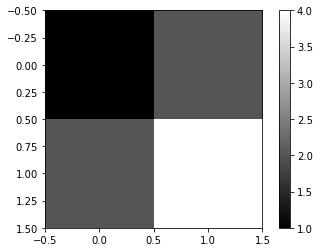

In [18]:
plt.imshow(imgtsr,cmap='gray')
plt.colorbar()

### 예비학습3: torchvision

`-` 이미지파일을 torchvision.io.read_image 를 이용하여 텐서로 만듦

In [21]:
imgtsr = torchvision.io.read_image('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/49081.png')
imgtsr

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0, 104, 253, 253, 253, 121,
          121,  76,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,  30, 156, 252, 252, 253,
          252, 247, 240, 240, 240, 148,  39,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

`-` 이 텐서는 (1,28,28)의 shape을 가짐

In [25]:
imgtsr.shape
# 맨 앞의 1은 RGB가 아니라 흑백이라서 1인 것

torch.Size([1, 28, 28])

In [31]:
imgtsr.reshape(28,28).shape

torch.Size([28, 28])

`-` imgtsr를 plt.imshow 로 시각화

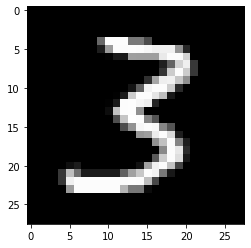

In [32]:
plt.imshow(imgtsr.reshape(28,28),cmap='gray')

### 데이터정리 

In [33]:
threes = (path/'training/3').ls()
sevens = (path/'training/7').ls()
len(threes),len(sevens)

(6131, 6265)

In [35]:
X3 = torch.stack([torchvision.io.read_image(str(threes[i])) for i in range(6131)])
X7 = torch.stack([torchvision.io.read_image(str(sevens[i])) for i in range(6265)])

# 숫자 3과 숫자 7의 tensor를 저장

In [36]:
X3.shape,X7.shape

(torch.Size([6131, 1, 28, 28]), torch.Size([6265, 1, 28, 28]))

In [37]:
X=torch.concat([X3,X7])
X.shape

torch.Size([12396, 1, 28, 28])

In [39]:
Xnp = X.reshape(-1,1*28*28).float()
Xnp.shape
# 12396장을 782개의 feature로 바꿨음

torch.Size([12396, 784])

In [41]:
y = torch.tensor([0.0]*6131 + [1.0]*6265).reshape(-1,1) 
y.shape
# 0은 숫자 3의 label, 1은 숫자 7의 label

torch.Size([12396, 1])

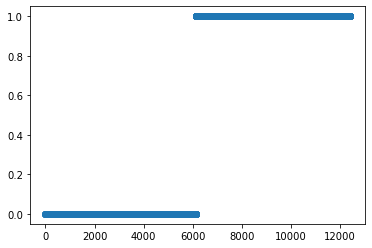

In [42]:
plt.plot(y,'o')

### 학습 (숙제: 스스로 확인해 볼 것) 

`-` 네트워크의 설계

In [ ]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1*28*28,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)

- $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,30)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,30)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [ ]:
loss_fn = torch.nn.BCELoss()

In [ ]:
optimizr = torch.optim.Adam(net.parameters())

In [ ]:
for epoc in range(200):
    ## 1
    yhat = net(Xnp) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

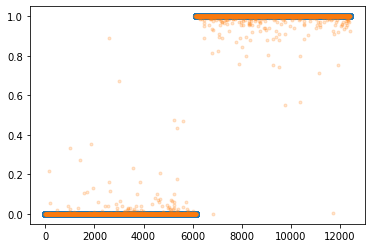

In [ ]:
plt.plot(y,'o')
plt.plot(net(Xnp).data,'.',alpha=0.2)

- 대부분 잘 적합되었음 

---

## 숙제 

(1) 숫자0과 숫자1을 구분하는 네트워크를 아래와 같은 구조로 설계하라

$$\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,64)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,64)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

위에서 $a_1$은 relu를, $a_2$는 sigmoid를 의미한다. 

- "y=0"은 숫자0을 의미하도록 하고 "y=1"은 숫자1을 의미하도록 설정하라. 

In [116]:
zeros = (path/'training/0').ls()
ones = (path/'training/1').ls()

X0 = torch.stack([torchvision.io.read_image(str(zeros[i])) for i in range(len(zeros))])
X1 = torch.stack([torchvision.io.read_image(str(ones[i])) for i in range(len(ones))])


X=torch.concat([X0,X1])


Xnp = X.reshape(-1,1*28*28).float()


y = torch.tensor([0.0]*len(zeros) + [1.0]*len(ones)).reshape(-1,1) 


net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1*28*28,out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64,out_features=1),
    torch.nn.Sigmoid()
)

(2) 아래의 지침에 따라 200 epoch 학습을 진행하라.
- 손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss() 를 이용할 것. 
- 옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것. 

In [117]:
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.002)

In [118]:
for epoc in range(200):
    ## 1
    yhat = net(Xnp) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

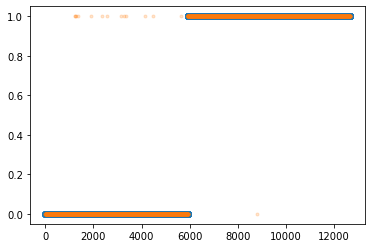

In [126]:
plt.plot(y,'o')
plt.plot(net(Xnp).data,'.',alpha=0.2)

(3) 아래의 지침에 따라 200 epoch 학습을 진행하라. 학습이 잘 되는가? 
- 손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss()를 사용하지 않고 수식을 직접 입력할 것.
- 옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것. 

In [110]:
def loss_fn(y,yhat):
    return -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))

optimizr = torch.optim.Adam(net.parameters(),lr=0.002)

In [111]:
for epoc in range(200):
    ## 1
    yhat = net(Xnp) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

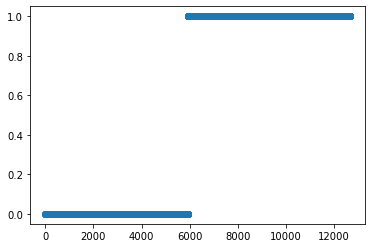

In [112]:
plt.plot(y,'o')
plt.plot(net(Xnp).data,'.',alpha=0.2)

(4) 아래의 지침에 따라 200 epoch 학습을 진행하라. 학습이 잘 되는가? 
- 이미지의 값을 0과 1사이로 규격화 하라. (Xnp = Xnp/255 를 이용하세요!)
- 손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss()를 사용하지 않고 수식을 직접 입력할 것.
- 옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것. 

In [113]:
Xnp = Xnp/255

In [114]:
for epoc in range(200):
    ## 1
    yhat = net(Xnp) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

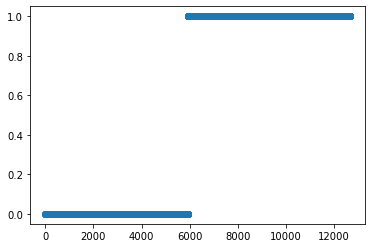

In [115]:
plt.plot(y,'o')
plt.plot(net(Xnp).data,'.',alpha=0.2)

(5) 아래와 같은 수식을 이용하여 accuracy를 계산하라. 

$\text{accuracy}=\frac{1}{n}\sum_{i=1}^n I(\tilde{y}_i=y_i)$
- $\tilde{y}_i = \begin{cases}
 1 & \hat{y}_i > 0.5 \\ 
 0 & \hat{y}_i \leq 0.5 
\end{cases}$ 
- $I(\tilde{y}_i=y_i) = \begin{cases} 1 & \tilde{y}_i=y_i \\ 0 & \tilde{y}_i \neq y_i \end{cases}$

단, $n$은 0과 1을 의미하는 이미지의 수 

In [147]:
np.array(y==net(Xnp)).mean()

0.990525069088038